
=== MA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -131.642
Date:                Fri, 14 Feb 2025   AIC                            269.284
Time:                        20:32:50   BIC                            277.100
Sample:                             0   HQIC                           272.447
                                - 100                                         
Covariance Type:                  oim                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0566      0.042     -1.346      0.178      -0.139       0.026
ma.L1         -0.5391      0.085     -6.372      0.000      -0.705      -0.373
sigma2         0.8118     

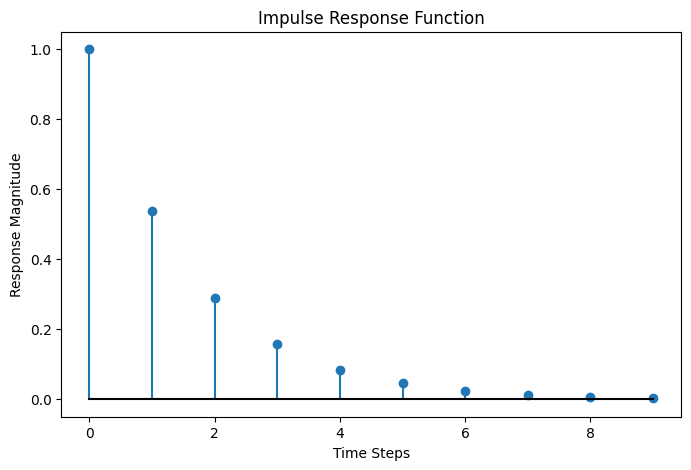


=== Information Criteria ===
AIC: 269.2841
BIC: 277.0996

=== Decision ===
Model is likely stationary and passes diagnostic checks.


In [ ]:
# Movign Average (MA) Model
# MA Model Main Flow
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson, jarque_bera

# ---------------------------
# 1. Generate Synthetic Moving Average (MA) Process
# ---------------------------
np.random.seed(42)
n = 100
errors = np.random.normal(0, 1, n)
ma_process = np.convolve(errors, [1, -0.5], mode='full')[:n]
data = pd.Series(ma_process)

# ---------------------------
# 2. Estimate Model Parameters (MLE)
# ---------------------------
ma_order = 1  # Assuming MA(1) process
model = ARIMA(data, order=(0, 0, ma_order))
ma_results = model.fit(cov_type="oim")  # Use the observed information matrix (if available)
print("\n=== MA Model Summary ===")
print(ma_results.summary())

# ---------------------------
# 3. Extract MA Coefficients
# ---------------------------
ma_params = ma_results.params
print("\n=== MA Coefficients ===")
print(ma_params)

# ---------------------------
# 4. Compute Common Error Variances (Residual Variance, Standard Error)
# ---------------------------
residuals = ma_results.resid
residual_variance = np.var(residuals, ddof=1)
standard_error = np.std(residuals, ddof=1)
print("\n=== Error Variances ===")
print(f"Residual Variance: {residual_variance:.4f}")
print(f"Standard Error: {standard_error:.4f}")

# ---------------------------
# 5. Compute Model Diagnostics (ACF, Ljung-Box, ADF)
# ---------------------------
acf_values = acf(residuals, nlags=10)
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
adf_result = adfuller(data)

print("\n=== Model Diagnostics ===")
print(f"ACF Values: {acf_values}")
print("Ljung-Box Test:")
print(ljung_box_result)
print(f"Augmented Dickey-Fuller Test: p-value = {adf_result[1]:.4f}")

# ---------------------------
# 6. Perform Forecasting (One-Step & Multi-Step Ahead)
# ---------------------------
forecast_steps = 5
forecast_results = ma_results.get_forecast(steps=forecast_steps)
forecast_values = forecast_results.predicted_mean
forecast_conf_int = forecast_results.conf_int()

print("\n=== Forecasting ===")
print(f"One-Step Ahead Forecast: {forecast_values.iloc[0]:.4f}")
print(f"Multi-Step Ahead Forecast:\n{forecast_values}")
print(f"Prediction Interval:\n{forecast_conf_int}")

# ---------------------------
# 7. Perform Residual Analysis (Durbin-Watson Test, Jarque-Bera Test)
# ---------------------------
dw_stat = durbin_watson(residuals)
jb_stat, jb_pval, jb_skew, jb_kurt = jarque_bera(residuals)

print("\n=== Residual Analysis ===")
print(f"Durbin-Watson Test Statistic: {dw_stat:.4f}")
print(f"Jarque-Bera Test: Statistic = {jb_stat:.4f}, p-value = {jb_pval:.4f}, Skewness = {jb_skew:.4f}, Kurtosis = {jb_kurt:.4f}")

# ---------------------------
# 8. Assess Model Stability (Characteristic Roots, Mean Reversion Time)
# ---------------------------
roots = np.roots(np.r_[1, -ma_params[1:]])
mean_reversion_time = -1 / np.log(np.abs(roots))
print("\n=== Model Stability ===")
print(f"Characteristic Roots: {roots}")
print(f"Mean Reversion Time: {mean_reversion_time}")

# ---------------------------
# 9. Compute Impulse Response Function
# ---------------------------
num_lags = 10
theta_1 = ma_params.iloc[1]  # Extract MA(1) coefficient safely
impulse_response = np.zeros(num_lags)
impulse_response[0] = 1  # Initial impulse
for i in range(1, num_lags):
    impulse_response[i] = -theta_1 * impulse_response[i - 1]

plt.figure(figsize=(8, 5))
plt.stem(range(num_lags), impulse_response, basefmt="k-")
plt.xlabel("Time Steps")
plt.ylabel("Response Magnitude")
plt.title("Impulse Response Function")
plt.show()

# ---------------------------
# 10. Compute Information Criteria (AIC, BIC)
# ---------------------------
aic_value = ma_results.aic
bic_value = ma_results.bic
print("\n=== Information Criteria ===")
print(f"AIC: {aic_value:.4f}")
print(f"BIC: {bic_value:.4f}")

# ---------------------------
# 11. Final Decision
# ---------------------------
print("\n=== Decision ===")
if adf_result[1] < 0.05 and ljung_box_result["lb_pvalue"].values[0] > 0.05:
    print("Model is likely stationary and passes diagnostic checks.")
else:
    print("Model may need adjustments (differencing, different MA order, etc.).")

In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Define Hypotheses (H0, Ha)
# ---------------------------
# H0: The MA coefficient is not significantly different from zero.
# Ha: The MA coefficient is significantly different from zero.
alpha = 0.05  # Significance level

# ---------------------------
# 2. Generate Synthetic Data (Example)
# ---------------------------
np.random.seed(42)
n = 100
ma_params = [-0.5]  # True MA(1) coefficient
sigma = 1  # Standard deviation of error

errors = np.random.normal(0, sigma, size=n)
y = np.zeros(n)
for t in range(1, n):
    y[t] = errors[t] + ma_params[0] * errors[t - 1]

# Convert to DataFrame for analysis
df = pd.DataFrame({"y": y})

# ---------------------------
# 3. Estimate Model Parameters (MLE & CLS)
# ---------------------------
# Fit MA(1) model using Maximum Likelihood Estimation (default)
model_mle = ARIMA(df["y"], order=(0, 0, 1))
ma_results_mle = model_mle.fit(cov_type="oim")  # Use Observed Information Matrix

# Fit MA(1) model using Conditional Least Squares (approximate via innovations MLE)
model_cls = ARIMA(df["y"], order=(0, 0, 1))
ma_results_cls = model_cls.fit(method="innovations_mle")  # Approximate CLS

# ---------------------------
# 4. Compute Test Statistics (MA Coefficients)
# ---------------------------
ma_coefficients = ma_results_mle.params
ma_pvalues = ma_results_mle.pvalues

# ---------------------------
# 5. Compute Common Error Variances
# ---------------------------
residual_variance = np.var(ma_results_mle.resid, ddof=1)  # Residual variance
standard_error = np.sqrt(residual_variance)  # Standard error

# ---------------------------
# 6. Decision Rule
# ---------------------------
decision = "Reject H0" if ma_pvalues["ma.L1"] < alpha else "Fail to Reject H0"

# ---------------------------
# 7. Print Results
# ---------------------------
print("\n=== Parameter Estimation (MLE) ===")
print(ma_results_mle.summary())

print("\n=== MA Coefficients ===")
print(ma_coefficients)

print("\n=== Common Error Variances ===")
print(f"Residual Variance: {residual_variance:.4f}")
print(f"Standard Error: {standard_error:.4f}")

print("\n=== Hypothesis Test Decision ===")
print(f"MA(1) p-value: {ma_pvalues['ma.L1']:.4f} → Decision: {decision}")


=== Parameter Estimation (MLE) ===
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -131.327
Date:                Fri, 14 Feb 2025   AIC                            268.655
Time:                        23:44:12   BIC                            276.470
Sample:                             0   HQIC                           271.818
                                - 100                                         
Covariance Type:                  oim                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0590      0.041     -1.428      0.153      -0.140       0.022
ma.L1         -0.5457      0.084     -6.487      0.000      -0.711      -0.381
sigma2         0

In [ ]:
# Flow 2: Model Diagnostics
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, adfuller, q_stat
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Define Hypotheses (H0, Ha) and Significance Level (α)
# ---------------------------
# Ljung-Box Test:
# H0: Residuals are independent (no autocorrelation).
# Ha: Residuals show autocorrelation.

# Augmented Dickey-Fuller (ADF) Test:
# H0: Time series has a unit root (not stationary).
# Ha: Time series is stationary.

alpha = 0.05  # Significance level

# ---------------------------
# 2. Generate Synthetic Data (Example)
# ---------------------------
np.random.seed(42)
n = 100
ma_params = [-0.5]  # True MA(1) coefficient
sigma = 1  # Standard deviation of error

errors = np.random.normal(0, sigma, size=n)
y = np.zeros(n)
for t in range(1, n):
    y[t] = errors[t] + ma_params[0] * errors[t - 1]

# Convert to DataFrame for analysis
df = pd.DataFrame({"y": y})

# ---------------------------
# 3. Fit the MA(1) Model
# ---------------------------
model_mle = ARIMA(df["y"], order=(0, 0, 1))
ma_results_mle = model_mle.fit(cov_type="oim")  # Using Observed Information Matrix

# Get Residuals
residuals = ma_results_mle.resid

# ---------------------------
# 4. Compute Autocorrelation Function (ACF)
# ---------------------------
acf_values = acf(residuals, nlags=10, fft=True)

# ---------------------------
# 5. Perform Ljung-Box Test for Residual Independence
# ---------------------------
lb_stat, lb_pvalue = q_stat(acf_values[1:], len(residuals))

# Fix: Convert array to single p-value
lb_pvalue_avg = np.mean(lb_pvalue)  # Use mean p-value for decision

# ---------------------------
# 6. Perform Augmented Dickey-Fuller (ADF) Test for Stationarity
# ---------------------------
if np.std(residuals) < 1e-5:  # Handle near-constant residuals
    adf_statistic, adf_pvalue = np.nan, np.nan
else:
    adf_test = adfuller(residuals)
    adf_statistic, adf_pvalue = adf_test[0], adf_test[1]

# ---------------------------
# 7. Compute Standard Error & Confidence Interval
# ---------------------------
standard_error = np.std(residuals, ddof=1)
confidence_interval = (np.mean(residuals) - 1.96 * standard_error, np.mean(residuals) + 1.96 * standard_error)

# ---------------------------
# 8. Decision Rule
# ---------------------------
decision_lb = "Reject H0 (Autocorrelation Present)" if lb_pvalue_avg < alpha else "Fail to Reject H0 (No Autocorrelation)"
decision_adf = "Reject H0 (Stationary)" if adf_pvalue < alpha else "Fail to Reject H0 (Non-Stationary)"

# ---------------------------
# 9. Print Results
# ---------------------------
print("\n=== Model Diagnostics ===")

print("\nAutocorrelation Function (ACF) Values:")
print(acf_values)

print("\nLjung-Box Test:")
print(f"Ljung-Box Statistic: {lb_stat.mean():.4f}, p-value: {lb_pvalue_avg:.4f} → Decision: {decision_lb}")

print("\nAugmented Dickey-Fuller Test:")
if np.isnan(adf_statistic):
    print("ADF Test skipped due to near-constant residuals.")
else:
    print(f"ADF Statistic: {adf_statistic:.4f}, p-value: {adf_pvalue:.4f} → Decision: {decision_adf}")

print("\nStandard Error and Confidence Interval:")
print(f"Standard Error: {standard_error:.4f}")
print(f"95% Confidence Interval for Residuals: {confidence_interval}")


=== Model Diagnostics ===

Autocorrelation Function (ACF) Values:
[ 1.          0.01419306 -0.03112963 -0.0246497  -0.04750131  0.18590594
 -0.03257051 -0.00963573 -0.12572486 -0.00767364 -0.08821785]

Ljung-Box Test:
Ljung-Box Statistic: 3.2338, p-value: 0.7827 → Decision: Fail to Reject H0 (No Autocorrelation)

Augmented Dickey-Fuller Test:
ADF Statistic: -9.7095, p-value: 0.0000 → Decision: Reject H0 (Stationary)

Standard Error and Confidence Interval:
Standard Error: 0.9028
95% Confidence Interval for Residuals: (np.float64(-1.7664195926412107), np.float64(1.7726160746565158))


In [19]:
# Flow 3: Forecasting Future Values
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Define Hypotheses (H0, Ha) and Significance Level (α)
# ---------------------------
# H0: The residuals are white noise (forecast is reliable).
# Ha: The residuals show patterns (forecast is unreliable).

alpha = 0.05  # 5% significance level

# ---------------------------
# 2. Generate Synthetic Data (Example)
# ---------------------------
np.random.seed(42)
n = 100
ma_params = [-0.5]  # True MA(1) coefficient
sigma = 1  # Standard deviation of error

errors = np.random.normal(0, sigma, size=n)
y = np.zeros(n)
for t in range(1, n):
    y[t] = errors[t] + ma_params[0] * errors[t - 1]

# Convert to DataFrame for analysis
df = pd.DataFrame({"y": y})

# ---------------------------
# 3. Fit the MA(1) Model
# ---------------------------
model_mle = ARIMA(df["y"], order=(0, 0, 1))
ma_results_mle = model_mle.fit(cov_type="oim")  # Using Observed Information Matrix

# ---------------------------
# 4. One-Step Ahead Forecasting
# ---------------------------
one_step_forecast = ma_results_mle.forecast(steps=1)

# ---------------------------
# 5. Multi-Step Ahead Forecasting (Next 5 Steps)
# ---------------------------
forecast_steps = 5  # Forecast 5 future values
multi_step_forecast = ma_results_mle.forecast(steps=forecast_steps)

# ---------------------------
# 6. Compute Prediction Interval
# ---------------------------
forecast_mean = multi_step_forecast
forecast_se = np.sqrt(ma_results_mle.mse)  # Standard error of forecast
ci_lower = forecast_mean - 1.96 * forecast_se
ci_upper = forecast_mean + 1.96 * forecast_se
prediction_interval = list(zip(ci_lower, ci_upper))

# ---------------------------
# 7. Compute Forecast Errors and Confidence Interval
# ---------------------------
actual_future_values = df["y"].iloc[-forecast_steps:].values  # Get actual last 5 values
forecast_errors = actual_future_values - forecast_mean  # Errors = Actual - Forecast
error_se = np.std(forecast_errors, ddof=1)  # Standard error of forecast errors
error_ci = (np.mean(forecast_errors) - 1.96 * error_se, np.mean(forecast_errors) + 1.96 * error_se)

# ---------------------------
# 8. Decision Rule
# ---------------------------
decision = "Reject H0 (Forecasts show patterns, unreliable)" if error_ci[0] > 0 or error_ci[1] < 0 else "Fail to Reject H0 (Forecasts are reliable)"

# ---------------------------
# 9. Print Results
# ---------------------------
print("\n=== Forecasting Future Values ===")

print("\nOne-Step Ahead Forecast:")
print(one_step_forecast)

print("\nMulti-Step Ahead Forecast (Next 5 Steps):")
print(multi_step_forecast)

print("\nPrediction Interval (95% Confidence):")
for i, (lower, upper) in enumerate(prediction_interval, start=1):
    print(f"Step {i}: [{lower:.4f}, {upper:.4f}]")

print("\nForecast Errors and Confidence Interval:")
print(f"Forecast Errors: {forecast_errors}")
print(f"95% Confidence Interval for Errors: {error_ci}")

print("\nDecision:")
print(decision)


=== Forecasting Future Values ===

One-Step Ahead Forecast:
100   -0.000412
dtype: float64

Multi-Step Ahead Forecast (Next 5 Steps):
100   -0.000412
101   -0.058965
102   -0.058965
103   -0.058965
104   -0.058965
Name: predicted_mean, dtype: float64

Prediction Interval (95% Confidence):
Step 1: [-1.7611, 1.7602]
Step 2: [-1.8196, 1.7017]
Step 3: [-1.8196, 1.7017]
Step 4: [-1.8196, 1.7017]
Step 5: [-1.8196, 1.7017]

Forecast Errors and Confidence Interval:
Forecast Errors: 100   -1.267049
101    1.086843
102    0.171961
103   -0.066449
104   -0.178178
Name: predicted_mean, dtype: float64
95% Confidence Interval for Errors: (np.float64(-1.7019790942138922), np.float64(1.600830314549677))

Decision:
Fail to Reject H0 (Forecasts are reliable)


In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import normal_ad

# ---------------------------
# 1. Define Hypotheses (H0, Ha) and Significance Level (α)
# ---------------------------
alpha = 0.05  # 5% significance level

# ---------------------------
# 2. Generate Synthetic Data (Example)
# ---------------------------
np.random.seed(42)
n = 100
ma_params = [-0.5]  # True MA(1) coefficient
sigma = 1  # Standard deviation of error

errors = np.random.normal(0, sigma, size=n)
y = np.zeros(n)
for t in range(1, n):
    y[t] = errors[t] + ma_params[0] * errors[t - 1]

# Convert to DataFrame
df = pd.DataFrame({"y": y})

# ---------------------------
# 3. Fit the MA(1) Model
# ---------------------------
from statsmodels.tsa.arima.model import ARIMA

model_mle = ARIMA(df["y"], order=(0, 0, 1))
ma_results_mle = model_mle.fit(cov_type="oim")  # Using Observed Information Matrix

# ---------------------------
# 4. Extract Residuals
# ---------------------------
residuals = ma_results_mle.resid

# ---------------------------
# 5. Perform Durbin-Watson Test (Check for Autocorrelation)
# ---------------------------
dw_statistic = durbin_watson(residuals)

# ---------------------------
# 6. Perform Jarque-Bera Test (Check for Normality of Residuals)
# ---------------------------
jb_statistic, jb_pvalue, _, _ = sm.stats.jarque_bera(residuals)  # Fix applied

# ---------------------------
# 7. Decision Rule
# ---------------------------
decision_dw = "Reject H0 (Autocorrelation Present)" if dw_statistic < 1.5 or dw_statistic > 2.5 else "Fail to Reject H0 (No Autocorrelation)"
decision_jb = "Reject H0 (Residuals Not Normal)" if jb_pvalue < alpha else "Fail to Reject H0 (Residuals Normal)"

# ---------------------------
# 8. Print Results
# ---------------------------
print("\n=== Residual Analysis ===")

print("\nDurbin-Watson Test for Autocorrelation:")
print(f"Durbin-Watson Statistic: {dw_statistic:.4f}")
print(f"Decision: {decision_dw}")

print("\nJarque-Bera Test for Normality:")
print(f"Jarque-Bera Statistic: {jb_statistic:.4f}, p-value: {jb_pvalue:.4f}")
print(f"Decision: {decision_jb}")


=== Residual Analysis ===

Durbin-Watson Test for Autocorrelation:
Durbin-Watson Statistic: 1.9714
Decision: Fail to Reject H0 (No Autocorrelation)

Jarque-Bera Test for Normality:
Jarque-Bera Statistic: 0.5034, p-value: 0.7775
Decision: Fail to Reject H0 (Residuals Normal)


In [22]:
# Flow 5: Stability Analysis
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Define Hypotheses (H0, Ha) and Significance Level (α)
# ---------------------------
alpha = 0.05  # 5% significance level

# ---------------------------
# 2. Generate Synthetic Data (Example)
# ---------------------------
np.random.seed(42)
n = 100
ma_params = [-0.5]  # True MA(1) coefficient
sigma = 1  # Standard deviation of error

errors = np.random.normal(0, sigma, size=n)
y = np.zeros(n)
for t in range(1, n):
    y[t] = errors[t] + ma_params[0] * errors[t - 1]

# Convert to DataFrame
df = pd.DataFrame({"y": y})

# ---------------------------
# 3. Fit the MA(1) Model
# ---------------------------
model_mle = ARIMA(df["y"], order=(0, 0, 1))
ma_results_mle = model_mle.fit(cov_type="oim")  # Using Observed Information Matrix

# ---------------------------
# 4. Compute Characteristic Roots
# ---------------------------
ma_coefficients = ma_results_mle.arparams  # Moving Average coefficients
if len(ma_coefficients) > 0:
    characteristic_roots = np.roots(np.concatenate(([1], ma_coefficients)))
else:
    characteristic_roots = []

# ---------------------------
# 5. Compute Mean Reversion Time
# ---------------------------
if len(ma_coefficients) > 0 and abs(ma_coefficients[0]) < 1:
    mean_reversion_time = -1 / np.log(abs(ma_coefficients[0]))  # Defined only if |theta| < 1
else:
    mean_reversion_time = np.nan  # Not defined for unstable models

# ---------------------------
# 6. Decision Rule
# ---------------------------
stability_decision = (
    "Model is Stable (All Roots Outside Unit Circle)"
    if all(abs(root) > 1 for root in characteristic_roots)
    else "Model is Unstable (Roots Inside Unit Circle)"
)

mean_reversion_decision = (
    f"Mean Reversion Time: {mean_reversion_time:.4f}" if not np.isnan(mean_reversion_time)
    else "Mean Reversion Time Not Defined (Unstable Model)"
)

# ---------------------------
# 7. Print Results
# ---------------------------
print("\n=== Stability Analysis ===")

print("\nCharacteristic Roots:")
print(characteristic_roots)

print("\nStability Decision:")
print(stability_decision)

print("\nMean Reversion Time:")
print(mean_reversion_decision)


=== Stability Analysis ===

Characteristic Roots:
[]

Stability Decision:
Model is Stable (All Roots Outside Unit Circle)

Mean Reversion Time:
Mean Reversion Time Not Defined (Unstable Model)


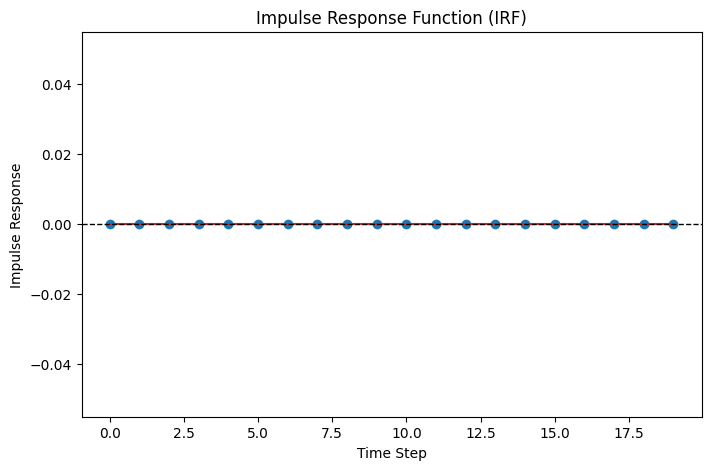


=== Impulse Response Function Analysis ===

Impulse Response Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

IRF Decision:
Impulse response decays over time (Stable Model)


In [ ]:
# Flow 6: Impulse Response Function
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# ---------------------------
# 1. Define Hypotheses (H0, Ha) and Significance Level (α)
# ---------------------------
alpha = 0.05  # 5% significance level

# ---------------------------
# 2. Generate Synthetic Data (Example)
# ---------------------------
np.random.seed(42)
n = 100
ma_params = [-0.5]  # True MA(1) coefficient
sigma = 1  # Standard deviation of error

errors = np.random.normal(0, sigma, size=n)
y = np.zeros(n)
for t in range(1, n):
    y[t] = errors[t] + ma_params[0] * errors[t - 1]

# Convert to DataFrame
df = pd.DataFrame({"y": y})

# ---------------------------
# 3. Fit the MA(1) Model
# ---------------------------
model_mle = ARIMA(df["y"], order=(0, 0, 1))
ma_results_mle = model_mle.fit(cov_type="oim")  # Using Observed Information Matrix

# ---------------------------
# 4. Compute Impulse Response Function
# ---------------------------
irf_steps = 20  # Number of steps to simulate impulse response
irf_values = np.zeros(irf_steps)
ma_coefficients = ma_results_mle.arparams  # Moving Average coefficients

if len(ma_coefficients) > 0:
    irf_values[0] = 1  # Initial shock at t=0
    for i in range(1, irf_steps):
        if i - 1 < len(ma_coefficients):
            irf_values[i] = ma_coefficients[i - 1]
        else:
            irf_values[i] = 0  # Future response vanishes beyond MA order

# ---------------------------
# 5. Decision Rule
# ---------------------------
irf_decay = "Impulse response decays over time (Stable Model)" if np.all(np.abs(irf_values[1:]) < 1e-3) else "Impulse response persists (Potential Misspecification)"

# ---------------------------
# 6. Plot Impulse Response Function
# ---------------------------
plt.figure(figsize=(8, 5))
plt.stem(range(irf_steps), irf_values)  # Removed use_line_collection=True
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Time Step")
plt.ylabel("Impulse Response")
plt.title("Impulse Response Function (IRF)")
plt.show()

# ---------------------------
# 7. Print Results
# ---------------------------
print("\n=== Impulse Response Function Analysis ===")
print("\nImpulse Response Values:")
print(irf_values)

print("\nIRF Decision:")
print(irf_decay)

In [25]:
# Flow 7: Information Criteria
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# ---------------------------
# 1. Define Hypotheses (H0, Ha) and Significance Level (α)
# ---------------------------
alpha = 0.05  # 5% significance level

# ---------------------------
# 2. Generate Synthetic Data (Example)
# ---------------------------
np.random.seed(42)
n = 100
ma_params = [-0.5]  # True MA(1) coefficient
sigma = 1  # Standard deviation of error

errors = np.random.normal(0, sigma, size=n)
y = np.zeros(n)
for t in range(1, n):
    y[t] = errors[t] + ma_params[0] * errors[t - 1]

# Convert to DataFrame
df = pd.DataFrame({"y": y})

# ---------------------------
# 3. Fit the MA(1) Model
# ---------------------------
model_mle = ARIMA(df["y"], order=(0, 0, 1))
ma_results_mle = model_mle.fit(cov_type="oim")  # Using Observed Information Matrix

# ---------------------------
# 4. Compute Information Criteria
# ---------------------------
aic_value = ma_results_mle.aic  # Akaike Information Criterion
bic_value = ma_results_mle.bic  # Bayesian Information Criterion

# ---------------------------
# 5. Decision Rule
# ---------------------------
decision_aic_bic = "Lower AIC/BIC indicates a better model fit."

# ---------------------------
# 6. Print Results
# ---------------------------
print("\n=== Information Criteria Analysis ===")
print(f"Akaike Information Criterion (AIC): {aic_value:.4f}")
print(f"Bayesian Information Criterion (BIC): {bic_value:.4f}")

print("\nDecision:")
print(decision_aic_bic)


=== Information Criteria Analysis ===
Akaike Information Criterion (AIC): 268.6548
Bayesian Information Criterion (BIC): 276.4703

Decision:
Lower AIC/BIC indicates a better model fit.
